In [1]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings

# Parallelization and monitoring
from itertools import product
from joblib import Parallel, delayed
from tqdm import tqdm

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

# Fitting
from stepmix.stepmix import StepMix
from src.model_fit import do_StepMix, do_kmeans, do_AHC, do_hdbscan

# Selection
from kneed import KneeLocator
from src.model_select import bootstrap_gap, compute_gap, get_gap

# Statistical tests
from scipy.stats import chi2
from src.hopkins import hopkins
from stepmix.bootstrap import blrt_sweep

# Visualization
from src.model_plot import plot_clusters, plot_cluster_profiles

# Preparation
## Data

In [2]:
var_list = [
    # Q2
    'clseusa', # 'clsetown', 'clsestat', 'clsenoam',
    # Q3
    'ambornin', 'amcit', 'amlived', 'amenglsh', 
    'amchrstn', 'amgovt', 'amfeel', # 'amancstr',
    # Q4
    'amcitizn', 'amshamed', 'belikeus', 'ambetter', 'ifwrong', # 'amsports', 'lessprd',
    # Q5
    'proudsss', 'proudgrp', 'proudpol', 'prouddem', 'proudeco',
    'proudspt', 'proudart', 'proudhis', 'proudmil', 'proudsci'
]

var_list_f = [var + "_f" for var in var_list]
var_list_n = [var + "_n" for var in var_list]

In [3]:
# Load imputed data
data2004_i = pd.read_parquet("data/data2004_i.parquet") 

In [4]:
# Dataset with categorical outcomes
data_f = data2004_i[var_list_f]

## Label encoding
data_f_lb = data_f.apply(lambda col: LabelEncoder().fit_transform(col))

## One-hot encoding (for BVR calculation)
columns = []
for col in data_f_lb.columns:
    for val in data_f_lb[col].unique():
        columns.append((data_f_lb[col] == val).astype(int).rename(f'{col}_{val}'))
data_f_oh = pd.concat(columns, axis=1)

# Dataset with numeric outcomes
data_n = data2004_i[var_list_n]

## Scaling and normalizing / not used
# scaler = MinMaxScaler(feature_range=(-1,1))
# data_n_scaled = scaler.fit_transform(data_n)
# normalizer = StandardScaler()
# data_n_norm = normalizer.fit_transform(data_n)

# Dataset with controls
controls = data2004_i[['sex', 'race_f', 'born_usa', 'party_fs', 'religstr_f', 'reltrad_f', 'region_f']]
controls_dum = pd.get_dummies(controls)

## Parameters
For the Silhouette and Dunn indices, the Mahnattan distance is used.

In [5]:
CVI = ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'dunn']
max_clust = 8
max_threads = -1

# 1. Fit models

## 1.1. Latent

*With the [StepMix package](https://github.com/Labo-Lacourse/stepmix?tab=readme-ov-file).*

*The methods used are **categorical** (multinomial) for LCA and **gaussian_tied** for LPA (where all Gaussian components share the same general covariance matrix). The default gaussian_diag (where each Gaussian component has its own diagonal covariance matrix) as well as gaussian_full (where each gaussian component has its own general covariance matrix) encountered severe convergence issues and produced highly unstable results. They also showed a tendency to overfit, as they yielded much higher log-likelihoods (LL) compared to the other models and proved very sensitive to scaling.*

*Models with covariates are fitted through the 1 step approach, where the EM algorithm is run on both the measurement and structural models. Overall, 5 initializations with kmeans++ and slightly relaxed convergence thresholds (abs_tol = rel_tol = 1e-4) proved enough to get consistent results.*

In [6]:
msrt = ['categorical', 'gaussian_tied']
covar = ['without', 'with']
latent_params = list(product(msrt, covar))

clust_range = range(1, max_clust+1)
latent_grid = product(clust_range, latent_params)

In [7]:
time1 = time.time()
results = Parallel(n_jobs=max_threads)(
    delayed(do_StepMix)(
        data_f_lb if msrt == 'categorical' else data_n,
        controls_dum if covar == 'with' else None,
        data_f_oh if msrt == 'categorical' else None,
        n, 
        msrt, 
        covar)
    for n, (msrt, covar) in tqdm(latent_grid, desc='Fitting latent models')
)
time2 = time.time()

latent_all = pd.DataFrame(results)
print(f"Time to fit latent models: {time2-time1:.2f} seconds")

Fitting latent models: 32it [00:00, 59.20it/s]


Time to fit latent models: 111.98 seconds


In [8]:
LCA_nocov = latent_all[latent_all['params'] == {'msrt': 'categorical', 'covar': 'without'}].reset_index(drop=True)
LCA_covs = latent_all[latent_all['params'] == {'msrt': 'categorical', 'covar': 'with'}].reset_index(drop=True)
LPA_nocov = latent_all[latent_all['params'] == {'msrt': 'gaussian_tied', 'covar': 'without'}].reset_index(drop=True)
LPA_covs = latent_all[latent_all['params'] == {'msrt': 'gaussian_tied', 'covar': 'with'}].reset_index(drop=True)

improv_covs_LCA = 100 * ((LCA_covs['sabic'] / LCA_nocov['sabic']) - 1)
improv_covs_LPA = 100 * ((LPA_covs['sabic'] / LPA_nocov['sabic']) - 1)
improv_gaussian_nocov = 100 * ((LPA_nocov['sabic'] / LCA_nocov['sabic']) - 1)
improv_gaussian_covs = 100 * ((LPA_covs['sabic'] / LCA_covs['sabic']) - 1)

In [9]:
improv = pd.DataFrame({
    "Clusters": clust_range,
    "LCA": improv_covs_LCA.round(1),
    "LPA": improv_covs_LPA.round(1),
    "no covar.": improv_gaussian_nocov.round(1),
    "covars.": improv_gaussian_covs.round(1)
})
improv.set_index('Clusters', inplace=True)
improv.columns = pd.MultiIndex.from_tuples([
    ('Covariates', 'LCA'), 
    ('Covariates', 'LPA'), 
    ('Gaussian', 'no covar.'), 
    ('Gaussian', 'covars.')
])

print("Evolution of SABIC (in %) brought by:")
print("- introducing covariates in LCA and LPA models")
print("- switching from LCA to LPA for models without and with covariates")
improv

Evolution of SABIC (in %) brought by:
- introducing covariates in LCA and LPA models
- switching from LCA to LPA for models without and with covariates


Covariates       Gaussian        
                LCA  LPA no covar. covars.
Clusters                                  
1               0.0  0.0      18.3    18.3
2               0.2  0.0      21.9    21.7
3               0.5  0.4      22.3    22.1
4               0.9  1.5      20.9    21.5
5               1.2  1.0      20.2    20.0
6               1.6  1.8      18.2    18.5
7               1.6  1.9      16.8    17.2
8               2.3  2.3      15.6    15.5

*The inclusion of covariates proves detrimental, as it increases the SABIC for both categorical and continuous models. While it slightly improves fit, it also introduces many additional free parameters, increasing the risk of overfitting. Moreover, covariates significantly increase computation time, so they will be excluded from subsequent analyses.*

*Switching from categorical to continuous models has mixed effects. It negatively impacts SABIC, which decreases steadily as the number of classes increases. This is due to differences in the number of free parameters: for Gaussian tied models, the parameter count starts higher but grows more slowly with additional classes. In terms of entropy, Gaussian models yield lower values up to five classes but higher values beyond that. Since their usefulness depends on the final number of classes chosen, they will be retained for further analysis.*

## 1.2. k-means

*With a custom implementation, as scikit-learn does not allow to change the linkage function.*

In [10]:
dist = ['euclidean', 'manhattan', 'chebyshev']
link = ['mean', 'median', 'medoid']
kmeans_params = list(product(dist, link))

clust_range = range(2, max_clust+1)
kmeans_grid = product(clust_range, kmeans_params)

In [11]:
time1 = time.time()
results = Parallel(n_jobs=max_threads)(
    delayed(do_kmeans)(data_n, n, dist, link) 
    for n, (dist, link) in tqdm(kmeans_grid, desc='Fitting KMeans models')
)
time2 = time.time()
print(f"Time to fit k-means models: {time2-time1:.2f} seconds")

kmeans_all = pd.DataFrame(results)

Fitting KMeans models: 63it [00:00, 585.17it/s]


Time to fit k-means models: 0.94 seconds


## 1.3. AHC

In [12]:
distances = ['manhattan', 'euclidean', 'chebyshev', 'hamming']
linkages = ['single', 'average', 'complete']
ahc_params = [*product(distances, linkages), ('euclidean', 'ward')]

clust_range = range(1, max_clust+1)
ahc_grid = product(clust_range, ahc_params)

In [13]:
time1 = time.time()
results = Parallel(n_jobs=max_threads)(
    delayed(do_AHC)(data_n, n, dist, link) 
    for n, (dist, link) in tqdm(ahc_grid, desc='Fitting AHC models')
)
time2 = time.time()
print(f"Time to fit AHC models: {time2-time1:.2f} seconds")

ahc_all = pd.DataFrame(results)

Fitting AHC models: 104it [00:00, 1726.83it/s]


Time to fit AHC models: 0.37 seconds


## 1.4. HDBSCAN

In [14]:
distances = ['manhattan', 'euclidean', 'chebyshev', 'mahalanobis', 'hamming']
min_cluster_sizes = range(2, 21)
min_samples_range = range(1, 21)
hdb_params = product(distances, min_cluster_sizes, min_samples_range)

In [15]:
time1 = time.time()
results = Parallel(n_jobs=max_threads)(
    delayed(do_hdbscan)(data_n, dist, min_clust, min_smpl)
    for dist, min_clust, min_smpl in tqdm(hdb_params, desc='Fitting HDBSCAN models')
)
time2 = time.time()
print(f"Time to fit HDBSCAN models: {time2-time1:.2f} seconds")

hdbscan_all = pd.DataFrame(results)

Fitting HDBSCAN models: 1900it [01:00, 31.65it/s] 


Time to fit HDBSCAN models: 61.46 seconds


## 1.5. Aggregate results and compare CVI

In [16]:
all_models = pd.concat([latent_all, kmeans_all, ahc_all, hdbscan_all]).reset_index(drop=True)
all_models.to_csv("output/models/all_models.csv", index=False)

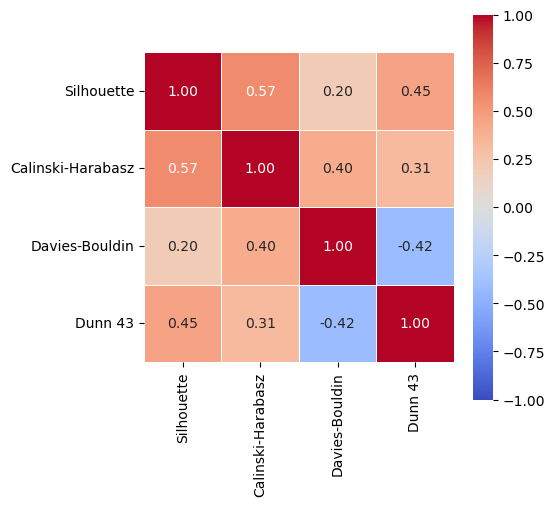

In [17]:
all_CVI = all_models[['silhouette', 'calinski_harabasz', 'davies_bouldin', 'dunn']]
labels = {
    'silhouette': 'Silhouette',
    'calinski_harabasz': 'Calinski-Harabasz',
    'davies_bouldin': 'Davies-Bouldin',
    'dunn': 'Dunn 43'
}

correlations = all_CVI.corr(method='spearman')
correlations = correlations.rename(index=labels, columns=labels)

plt.figure(figsize=(5, 5)) 
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, 
            square=True, linewidths=0.5, vmin=-1, vmax=1)
plt.show()

*The correlation between CVIs is generally low. Therefore, all can be retained for subsequent analyses.*

# 2. Select models

## 2.1. Gap statistics for latent models, kmeans and AHC

In [18]:
all_models = pd.concat([latent_all, kmeans_all, ahc_all]).reset_index(drop=True)

In [19]:
# Import results
# all_models = pd.read_csv('output/models/all_models.csv')
# all_models = all_models[all_models['n_clust'] <= max_clust]
# all_models = all_models[all_models['model'] != 'HDBSCAN']

In [20]:
# Convert params to dictionary to avoid errors afterwards
if isinstance(all_models['params'].iloc[0], str):
    all_models['params'] = all_models['params'].apply(ast.literal_eval)

*Step 1: compute the gap statistic for each model-config with 50 iters having proved more than enough to achieve a negligible sd*

In [21]:
# Excluding categorical models with covariates
latent_params = list([('categorical', 'without'),
                      ('gaussian_tied', 'without')])

params = {'kmeans': kmeans_params,
          'AHC': ahc_params,
          'latent': latent_params}

param_names = {'kmeans': ['dist', 'link'],
               'AHC': ['dist', 'link'],
               'latent': ['msrt', 'covar']}

models = ['kmeans', 'AHC', 'latent']

In [22]:
iters = 2

bootstrap_grid = [
    (model, {key: value for key, value in zip(param_names[model], param_values)}, n_val, n_iter)
    for model in models
    for param_values in params[model]
    for n_val in (range(1, max_clust+1) if model == 'latent' else range(2, max_clust+1))
    for n_iter in range(iters)
]

time1 = time.time()
results = Parallel(n_jobs=max_threads)(
    delayed(bootstrap_gap)(
        data = data_f_lb if model == 'latent' and config.get('msrt') == 'categorical' else data_n,
        controls = controls_dum if model == 'latent' and config.get('covar') == 'with' else None,
        bvr_data = data_f_oh if model == 'latent' and config.get('msrt') == 'categorical' else None,
        n = n,
        model = model,
        params = config,
        iter_num = iter_num)
    for model, config, n, iter_num in tqdm(bootstrap_grid, desc='Bootstrapping CVIs')
)
time2 = time.time()

bootstrap_results = pd.concat(results).reset_index(drop=True)
print(f"Time to compute gap statistics: {time2-time1:.2f} seconds")

Bootstrapping CVIs: 100%|██████████| 340/340 [00:01<00:00, 176.02it/s]


Time to compute gap statistics: 63.54 seconds


In [23]:
model_grid = [
    (model, dict(zip(param_names[model], param_values)))
    for model in models
    for param_values in params[model]
]

gap_values = []

for model, config in model_grid:
    rows_id = ((bootstrap_results['model'] == model) & (bootstrap_results['params'] == config))    
    bs_select_res = bootstrap_results[rows_id]
    gap_stats = compute_gap(bs_select_res, all_models, model, config, CVI)
    gap_values.append(gap_stats)

gap_values = pd.concat(gap_values, ignore_index=True)

*Step 2: identify the optimal number of clusters for each model-config*

In [24]:
# Create df to store results
cols = ['model', 'params', 'n_clust'] + \
       [index for index in CVI] + \
       [f'{index}_gap' for index in CVI]

candidate_models = pd.DataFrame(columns=cols)
candidate_models['model'] = candidate_models['model'].astype('object')
candidate_models['params'] = candidate_models['params'].astype('object')

float_cols = [col for col in cols if col not in ['model', 'params', 'n_clust'] + CVI]
candidate_models[float_cols] = candidate_models[float_cols].astype('float64')
int_cols = [col for col in cols if col in ['n_clust'] + CVI]
candidate_models[int_cols] = candidate_models[int_cols].astype('int64')

In [25]:
# Find best n
for model, config in model_grid:
    for index in CVI:
        best_n = get_gap(gap_values, model, config, index)

        # Check if a best value has been identified
        if best_n != 'none':
            row_id = ((candidate_models['model'] == model) & 
                      (candidate_models['params'] == config) &
                      (candidate_models['n_clust'] == best_n))
            
            # Check if the corresponding row exists in the df
            if candidate_models[row_id].empty:

                model_id = ((all_models['model'] == model) & 
                           (all_models['params'] == config) &
                           (all_models['n_clust'] == best_n))
                
                new_row = {
                    'model': model,
                    'params': config,
                    'n_clust': best_n,
                    'min_clust_size': all_models.loc[model_id, 'min_clust_size'].values[0],
                    'max_clust_size': all_models.loc[model_id, 'max_clust_size'].values[0],
                    'silhouette': all_models.loc[model_id, 'silhouette'].values[0],
                    'calinski_harabasz': all_models.loc[model_id, 'calinski_harabasz'].values[0],
                    'davies_bouldin': all_models.loc[model_id, 'davies_bouldin'].values[0],
                    'dunn': all_models.loc[model_id, 'dunn'].values[0],
                    f'{index}_gap': 1
                }
                
                new_row = pd.DataFrame([new_row])
                candidate_models = pd.concat([candidate_models, new_row], ignore_index=True)

            # Otherwise, update the existing row
            else:
                candidate_models.loc[row_id, f'{index}_gap'] = 1

In [26]:
candidate_models.to_csv("output/models/candidate_models.csv", index=False)

*Step 3: identify the best model for each class*

In [27]:
CVI_results = {}

for index in CVI:
    CVI_results[index] = []
    df = candidate_models[candidate_models[f'{index}_gap'] == 1]
    
    for model in models:
        sub_df = df[df['model'] == model]

        if sub_df.empty:
            continue
        else:
            if index == 'davies_bouldin':
                best_mod = sub_df.sort_values(index, ascending=True).iloc[0]
            else:
                best_mod = sub_df.sort_values(index, ascending=False).iloc[0]
            CVI_results[index].append(best_mod)

In [28]:
best_sil = pd.DataFrame(CVI_results['silhouette'])
best_ch = pd.DataFrame(CVI_results['calinski_harabasz'])
best_db = pd.DataFrame(CVI_results['davies_bouldin'])
best_dunn = pd.DataFrame(CVI_results['dunn'])

## 2.2. Min/max for HDBSCAN

In [29]:
best_sil = pd.concat([best_sil, hdbscan_all.sort_values('silhouette', ascending=False).iloc[0:1]], axis=0)
best_ch = pd.concat([best_ch, hdbscan_all.sort_values('calinski_harabasz', ascending=False).iloc[0:1]], axis=0)
best_db = pd.concat([best_db, hdbscan_all.sort_values('davies_bouldin', ascending=True).iloc[0:1]], axis=0)
best_dunn = pd.concat([best_dunn, hdbscan_all.sort_values('dunn', ascending=False).iloc[0:1]], axis=0)

In [30]:
best_sil = best_sil.drop(columns=[col for col in best_sil.columns if col.endswith(('elbow', 'abs', 'gap'))])
best_ch = best_ch.drop(columns=[col for col in best_ch.columns if col.endswith(('elbow', 'abs', 'gap'))])
best_db = best_db.drop(columns=[col for col in best_db.columns if col.endswith(('elbow', 'abs', 'gap'))])
best_dunn = best_dunn.drop(columns=[col for col in best_dunn.columns if col.endswith(('elbow', 'abs', 'gap'))])

## 2.3. Fit criteria for latent models

In [31]:
latent_stats = latent_all.drop(columns=['silhouette', 'calinski_harabasz', 'davies_bouldin', 'dunn'])

In [32]:
def disp_params(d):
    return f"{d['msrt']} {d['covar']} covariates"

### 2.3.1. Absolute value for AIC / BIC / SABIC / entropy

In [33]:
best_aic = latent_all.sort_values('aic', ascending=True).iloc[0]
best_bic = latent_all.sort_values('bic', ascending=True).iloc[0]
best_sabic = latent_all.sort_values('sabic', ascending=True).iloc[0]
best_entropy = latent_all.sort_values('relative_entropy', ascending=False).iloc[0]

print(f"Model minimizing AIC is {disp_params(best_aic['params'])} and {best_aic['n_clust']} clusters.")
print(f"Model minimizing BIC is {disp_params(best_bic['params'])} and {best_bic['n_clust']} clusters.")
print(f"Model minimizing SABIC is {disp_params(best_sabic['params'])} and {best_sabic['n_clust']} clusters.")
print(f"Model maximizing entropy is {disp_params(best_entropy['params'])} and {best_entropy['n_clust']} clusters.")

Model minimizing AIC is categorical with covariates and 7 clusters.
Model minimizing BIC is categorical without covariates and 4 clusters.
Model minimizing SABIC is categorical without covariates and 3 clusters.
Model maximizing entropy is gaussian_tied without covariates and 2 clusters.


### 2.3.2. Elbow method for AIC / BIC / SABIC / entropy

In [34]:
def elbow_method(df, val_index):
    res = df.dropna(subset=[val_index])
    x = res['n_clust']
    y = res[val_index]

    if val_index == 'relative_entropy':
        knee_locator = KneeLocator(x, y, curve='concave', direction='increasing')
    else:
        knee_locator = KneeLocator(x, y, curve='convex', direction='decreasing')
    
    return res[res["n_clust"] == knee_locator.knee]

def best_elbow_model(index):
    candidate_models = pd.DataFrame()

    for msrt in ['categorical', 'gaussian_tied']:
        for covar in ['without', 'with']:
            mask = (latent_stats['params'] == {'msrt': msrt, 'covar': covar})
            models = latent_stats[mask]
            elbow_res = elbow_method(models, index)
            if elbow_res is not None:
                candidate_models = pd.concat([candidate_models, elbow_res], ignore_index=True)
    
    if candidate_models.empty:
        return None
    return candidate_models.sort_values(index, ascending=True).iloc[0]

In [35]:
best_aic = best_elbow_model('aic')
best_bic = best_elbow_model('bic')
best_sabic = best_elbow_model('sabic')
best_entropy = best_elbow_model('relative_entropy')

print(f"Best model according to the Elbow method applied to...")

if best_aic is None: print("- AIC is None")
else: print(f"- AIC is {disp_params(best_aic['params'])} and {best_aic['n_clust']} clusters.")

if best_bic is None: print("- BIC is None")
else: print(f"- BIC is {disp_params(best_bic['params'])} and {best_bic['n_clust']} clusters.")

if best_sabic is None: print("- SABIC is None")
else: print(f"- SABIC is {disp_params(best_sabic['params'])} and {best_sabic['n_clust']} clusters.")

if best_entropy is None: print("- Entropy is None")
else: print(f"- Relative entropy is {disp_params(best_entropy['params'])} and {best_entropy['n_clust']} clusters")

Best model according to the Elbow method applied to...
- AIC is categorical with covariates and 3 clusters.
- BIC is categorical without covariates and 3 clusters.
- SABIC is categorical without covariates and 2 clusters.
- Relative entropy is categorical without covariates and 2 clusters


### 2.3.3. Statistical tests for log-likelihood
*LRT - not advisable for comparing models with $k$ and $k-1$ classes as the resulting test statistics does not converge towards a $\chi^2$ distribution under the null hypothesis. The implementation below compares each model to the 1-class model.*

In [36]:
def LRT(models):
    # LRT test
    l2_stat = - 2 * (models['LL'].iloc[0] - models['LL'])
    l2_df = models['df'] - models['df'].iloc[0]
    l2_p_val = 1 - chi2.cdf(l2_stat, l2_df)

    # L2 reduction
    l2_red = 1 - (models['LL'] / models['LL'].iloc[0])

    results = pd.DataFrame({
        'L2': l2_stat,
        'L2 df': l2_df,
        'LRT pval': l2_p_val,
        'ΔL2 (%)': 100 * l2_red
    }, index=models.index)
    
    return results

In [37]:
for msrt in ['categorical', 'gaussian_tied']:
    for covar in ['without', 'with']:
        mask = (latent_stats['params'] == {'msrt': msrt, 'covar': covar})
        models = latent_stats[mask]
        lrt_results = LRT(models)
        latent_stats.loc[mask, ['L2', 'L2 df', 'LRT pval', 'ΔL2 (%)']] = lrt_results.values

*BLRT - not implemented in StepMix for models with covariates.*

In [38]:
iters = 2

opt_params = {
    'method': 'gradient',
    'intercept': True,
    'max_iter': 1000
}

time1 = time.time()
for msrt in ['categorical', 'gaussian_tied']:
    latent_mod = StepMix(
        measurement = msrt,
        n_init = 3,
        init_params = 'kmeans',
        abs_tol=1e-4,
        rel_tol=1e-4,
        structural_params = opt_params,
        progress_bar = 0)
 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)

        blrt = blrt_sweep(
            latent_mod,
            data_f_lb if msrt == 'categorical' else data_n,
            low=1,
            high=max_clust,
            n_repetitions=iters)

        # Add a row for the saturated model
        blrt = pd.concat([pd.DataFrame({'p': [np.nan]}), blrt]).reset_index(drop=True)

    mask = (latent_stats['params'] == {'msrt': msrt, 'covar': 'without'})
    latent_stats.loc[mask, ['BLR pval']] = blrt.values
time2 = time.time()

Testing 1 vs. 2 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00, 15.77it/s, max_LL=-3.06e+4, median_LL=-3.07e+4, min_LL=-3.07e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00, 12.90it/s, max_LL=-3.06e+4, median_LL=-3.06e+4, min_LL=-3.07e+4]


Testing 2 vs. 3 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00, 13.91it/s, max_LL=-2.87e+4, median_LL=-2.88e+4, min_LL=-2.89e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00, 11.25it/s, max_LL=-2.87e+4, median_LL=-2.87e+4, min_LL=-2.88e+4]


Testing 3 vs. 4 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00, 12.56it/s, max_LL=-2.82e+4, median_LL=-2.86e+4, min_LL=-2.91e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  8.31it/s, max_LL=-2.81e+4, median_LL=-2.82e+4, min_LL=-2.83e+4]


Testing 4 vs. 5 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  4.59it/s, max_LL=-2.82e+4, median_LL=-2.83e+4, min_LL=-2.84e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  6.09it/s, max_LL=-2.74e+4, median_LL=-2.78e+4, min_LL=-2.81e+4]


Testing 5 vs. 6 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  3.65it/s, max_LL=-2.77e+4, median_LL=-2.77e+4, min_LL=-2.77e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  4.49it/s, max_LL=-2.75e+4, median_LL=-2.76e+4, min_LL=-2.77e+4]


Testing 6 vs. 7 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  3.99it/s, max_LL=-2.72e+4, median_LL=-2.75e+4, min_LL=-2.78e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, max_LL=-2.71e+4, median_LL=-2.74e+4, min_LL=-2.77e+4]


Testing 7 vs. 8 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, max_LL=-2.68e+4, median_LL=-2.68e+4, min_LL=-2.68e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  2.53it/s, max_LL=-2.67e+4, median_LL=-2.67e+4, min_LL=-2.68e+4]



BLRT Sweep Results
                   p
Test                
1 vs. 2 classes  0.0
2 vs. 3 classes  0.0
3 vs. 4 classes  0.5
4 vs. 5 classes  0.5
5 vs. 6 classes  1.0
6 vs. 7 classes  0.0
7 vs. 8 classes  0.5
Testing 1 vs. 2 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00, 20.37it/s, max_LL=-3.5e+4, median_LL=-3.51e+4, min_LL=-3.52e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00, 11.88it/s, max_LL=-3.5e+4, median_LL=-3.51e+4, min_LL=-3.52e+4]


Testing 2 vs. 3 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00, 11.63it/s, max_LL=-3.5e+4, median_LL=-3.5e+4, min_LL=-3.5e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00, 11.09it/s, max_LL=-3.44e+4, median_LL=-3.44e+4, min_LL=-3.44e+4]


Testing 3 vs. 4 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00, 10.68it/s, max_LL=-3.44e+4, median_LL=-3.45e+4, min_LL=-3.46e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  8.96it/s, max_LL=-3.41e+4, median_LL=-3.43e+4, min_LL=-3.44e+4]


Testing 4 vs. 5 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  7.16it/s, max_LL=-3.39e+4, median_LL=-3.41e+4, min_LL=-3.42e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  7.29it/s, max_LL=-3.39e+4, median_LL=-3.4e+4, min_LL=-3.4e+4]  


Testing 5 vs. 6 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  6.50it/s, max_LL=-3.36e+4, median_LL=-3.4e+4, min_LL=-3.44e+4] 



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  5.49it/s, max_LL=-3.34e+4, median_LL=-3.35e+4, min_LL=-3.36e+4]


Testing 6 vs. 7 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  5.51it/s, max_LL=-3.35e+4, median_LL=-3.36e+4, min_LL=-3.37e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  7.04it/s, max_LL=-3.34e+4, median_LL=-3.36e+4, min_LL=-3.37e+4]


Testing 7 vs. 8 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  6.08it/s, max_LL=-3.34e+4, median_LL=-3.35e+4, min_LL=-3.36e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 2/2 [00:00<00:00,  6.02it/s, max_LL=-3.34e+4, median_LL=-3.35e+4, min_LL=-3.36e+4]


BLRT Sweep Results
                   p
Test                
1 vs. 2 classes  0.0
2 vs. 3 classes  1.0
3 vs. 4 classes  0.0
4 vs. 5 classes  0.0
5 vs. 6 classes  1.0
6 vs. 7 classes  0.0
7 vs. 8 classes  0.0


In [39]:
print(f"Time to compute BLRT: {time2-time1:.2f} seconds")

Time to compute BLRT: 14.51 seconds


In [40]:
LCA = latent_stats[latent_stats['params'] == {'msrt': 'categorical', 'covar': 'without'}].reset_index(drop=True)
LPA = latent_stats[latent_stats['params'] == {'msrt': 'gaussian_tied', 'covar': 'without'}].reset_index(drop=True)

LCA.to_csv("output/models/bootstrapped_LCA.csv", index=False)
LPA.to_csv("output/models/bootstrapped_LPA.csv", index=False)

In [41]:
if LCA[LCA['BLR pval'] > 0.05].empty:
    best_LCA = None
else:
    best_LCA = LCA[LCA['BLR pval'] > 0.05].iloc[0]['n_clust']

if LPA[LPA['BLR pval'] > 0.05].empty:
    best_LPA = None
else:
    best_LPA = LPA[LPA['BLR pval'] > 0.05].iloc[0]['n_clust']    

print(f"Optimal number of clusters for LCA according to BLRT is {best_LCA}.")
print(f"Optimal number of clusters for LPA according to BLRT is {best_LPA}.")

Optimal number of clusters for LCA according to BLRT is 4.
Optimal number of clusters for LPA according to BLRT is 3.


*BVRT - not advisable without bootstrapping as the $\chi^2$ statistic calculated from the contingency table does not converge towards a $\chi^2$ distribution. The bootstrapping for the gap statistic and the BLRT cannot be used as they require samples generated under different assumptions.*

In [42]:
# Raw
sig_mods = latent_stats[latent_stats['chi2_pval'] > 0.05].shape[0]
print(f"Number of models where the local independance assumption holds is {sig_mods}.")

Number of models where the local independance assumption holds is 0.


In [43]:
# Bootstrapped

# For each model...
## Refit on the original dataset and extract coefficients
## Create a new dataset using those coefficient (= under the null hypothesis that the model is valid)
## Draw B replication samples with replacements from this new dataset
## Fit the model on those samples (parallelization at that moment will be more effective for B > max_threads)
## Let s be the number of bootstrapped models having a larger L2 than the original model
## The bootstrapped p-val for the chi2 test is: (s+1)/(B+1)

*Results*

In [44]:
LCA.drop(columns=['model', 'params'])

,n_clust,min_clust_size,max_clust_size,aic,bic,sabic,relative_entropy,df,LL,chi2_stat,chi2_pval,classif_error,L2,L2 df,LRT pval,ΔL2 (%),BLR pval
0,1,1215,1215,61663.981832,62133.411773,62494.612077,NaN,92.0,-25.300404,94283.033844,0.0,0.000000,-0.000000,0.0,NaN,0.000000,NaN
1,2,425,790,58157.369055,59101.331436,59827.658134,0.874267,185.0,-23.780810,46233.577304,0.0,0.035228,3.039187,93.0,1.0,6.006203,0.0
2,3,261,539,56974.897707,58393.392528,59484.845621,0.857562,278.0,-23.217653,36424.721677,0.0,0.063823,4.165501,186.0,1.0,8.232085,0.0
3,4,133,422,56174.938156,58067.965417,59524.544904,0.883893,371.0,-22.811909,30179.925540,0.0,0.063466,4.976991,279.0,1.0,9.835793,0.5
4,5,98,423,55732.424147,58099.983848,59921.689730,0.887759,464.0,-22.553261,28289.797917,0.0,0.071185,5.494286,372.0,1.0,10.858100,0.5
5,6,89,312,55649.818848,58491.910989,60678.743265,0.882702,557.0,-22.442724,27407.053956,0.0,0.085158,5.715360,465.0,1.0,11.294998,1.0
6,7,90,317,55759.446474,59076.071055,61628.029726,0.900669,650.0,-22.411295,27848.914100,0.0,0.071776,5.778218,558.0,1.0,11.419222,0.0
7,8,80,285,55552.333418,59343.490440,62260.575505,0.882781,743.0,-22.249520,25785.866770,0.0,0.094904,6.101768,651.0,1.0,12.058638,0.5


In [45]:
LPA.drop(columns=['model', 'params', 'chi2_stat', 'chi2_pval'])

,n_clust,min_clust_size,max_clust_size,aic,bic,sabic,relative_entropy,df,LL,classif_error,L2,L2 df,LRT pval,ΔL2 (%),BLR pval
0,1,1215,1215,71205.749105,72731.396412,73905.297401,NaN,299.0,-29.056687,0.000000,-0.000000,0.0,NaN,0.000000,NaN
1,2,290,925,70008.417600,71656.524892,72924.652047,0.992478,323.0,-28.544205,0.001911,1.024964,24.0,1.0,1.763732,0.0
2,3,59,867,69610.456692,71381.023968,72743.377289,0.986272,347.0,-28.360682,0.005807,1.392010,48.0,1.0,2.395335,1.0
3,4,55,862,68611.015296,70504.042557,71960.622045,0.989959,371.0,-27.929636,0.005519,2.254102,72.0,1.0,3.878801,0.0
4,5,56,654,68470.821552,70486.308798,72037.114452,0.958843,395.0,-27.852190,0.023168,2.408994,96.0,1.0,4.145335,0.0
5,6,46,658,67966.107470,70104.054700,71749.086520,0.987495,419.0,-27.624736,0.009199,2.863903,120.0,1.0,4.928130,1.0
6,7,33,638,67963.457881,70223.865095,71963.123082,0.966495,443.0,-27.603892,0.021860,2.905589,144.0,1.0,4.999864,0.0
7,8,31,443,67758.399751,70141.266950,71974.751103,0.880515,467.0,-27.499753,0.111180,3.113868,168.0,1.0,5.358264,0.0


# 3. Results

In [46]:
def refit_best_model(df):
    model = df.loc[0, 'model']
    config = df.loc[0, 'params']
    n_clust = int(df.loc[0, 'n_clust'])

    if model == 'latent':
        results = do_StepMix(data_f_lb if config['msrt'] == 'categorical' else data_n, n_clust, refit = True, **config)

    elif model == 'kmeans':
        results = do_kmeans(data_n, n_clust, refit = True, **config)
    
    elif model == 'AHC':
        results = do_AHC(data_n, n_clust, refit = True, **config)
    
    elif model == 'HDBSCAN':
        results = do_hdbscan(data_n, refit = True, **config)

    return results

## 3.1. Silhouette

In [47]:
sil = best_sil.sort_values('silhouette', ascending=False).drop(columns=['calinski_harabasz', 'davies_bouldin', 'dunn']).reset_index(drop=True)
sil

,model,params,n_clust,silhouette,min_clust_size,max_clust_size,noise
0,AHC,"{'dist': 'chebyshev', 'link': 'average'}",2,0.519963,1.0,1214.0,NaN
1,HDBSCAN,"{'dist': 'manhattan', 'min_clust': 7, 'min_smp...",2,0.465662,7.0,1201.0,0.576132
2,latent,"{'msrt': 'gaussian_tied', 'covar': 'without'}",5,0.136222,56.0,654.0,NaN
3,kmeans,"{'dist': 'manhattan', 'link': 'median'}",5,0.088893,109.0,493.0,NaN


In [48]:
pred_clust_sil = refit_best_model(sil)

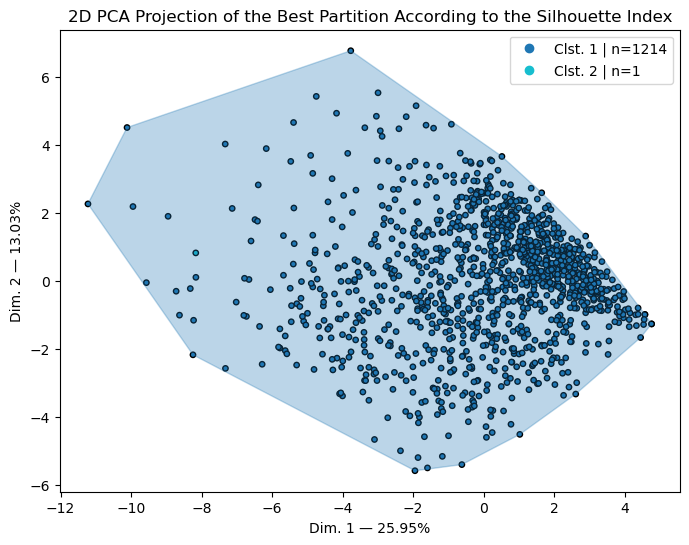

In [49]:
plot_clusters(
    data_f_lb if (sil.loc[0, 'model'] == 'latent') and (sil.loc[0, 'params'].get('msrt') == 'categorical') else data_n,
    pred_clust_sil,
    '2D PCA Projection of the Best Partition According to the Silhouette Index')

In [50]:
if np.unique(pred_clust_sil, return_counts=True)[1].min() > 5:
    plot_cluster_profiles(data_n, pred_clust_sil, feature_names = var_list, sd = 1, title = 'Silhouette')

## 3.2. Calinski-Harabasz

In [51]:
ch = best_ch.sort_values('calinski_harabasz', ascending=False).drop(columns=['silhouette', 'davies_bouldin', 'dunn']).reset_index(drop=True)
ch

,model,params,n_clust,calinski_harabasz,min_clust_size,max_clust_size,noise
0,kmeans,"{'dist': 'manhattan', 'link': 'median'}",3,149.577518,186.0,558.0,NaN
1,latent,"{'msrt': 'categorical', 'covar': 'without'}",4,105.190719,133.0,422.0,NaN
2,HDBSCAN,"{'dist': 'manhattan', 'min_clust': 2, 'min_smp...",2,103.348489,2.0,809.0,33.251029
3,AHC,"{'dist': 'euclidean', 'link': 'complete'}",4,75.972241,22.0,891.0,NaN


In [52]:
pred_clust_ch = refit_best_model(ch)

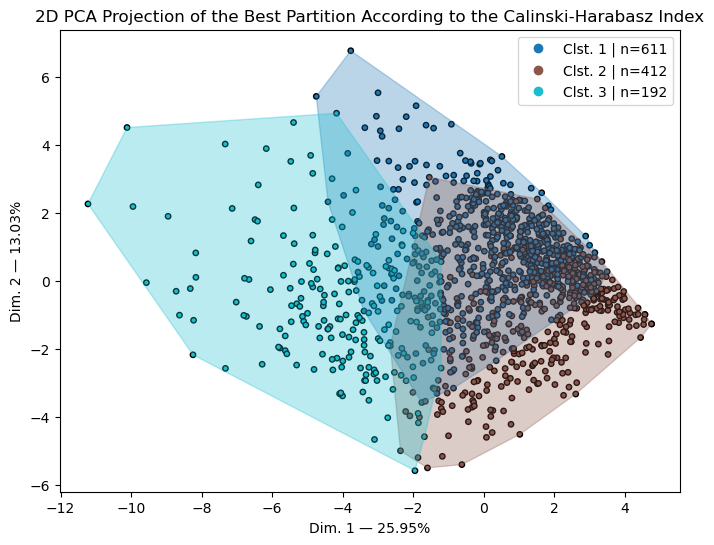

In [53]:
plot_clusters(
    data_f_lb if (ch.loc[0, 'model'] == 'latent') and (ch.loc[0, 'params'].get('msrt') == 'categorical') else data_n, 
    pred_clust_ch,
    '2D PCA Projection of the Best Partition According to the Calinski-Harabasz Index')

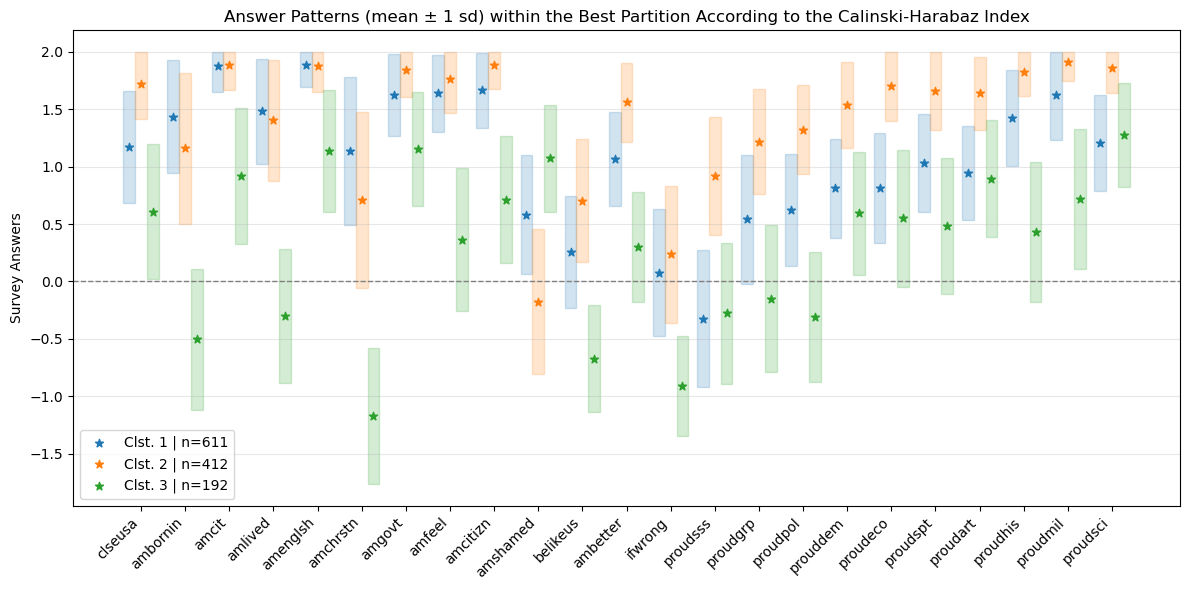

In [54]:
if np.unique(pred_clust_ch, return_counts=True)[1].min() > 5:
    plot_cluster_profiles(data_n, pred_clust_ch, feature_names = var_list, sd = 1, title = 'Calinski-Harabaz')

## 3.3. Davies-Bouldin

In [55]:
db = best_db.sort_values('davies_bouldin', ascending=True).drop(columns=['silhouette', 'calinski_harabasz', 'dunn']).reset_index(drop=True)
db

,model,params,n_clust,davies_bouldin,min_clust_size,max_clust_size,noise
0,AHC,"{'dist': 'chebyshev', 'link': 'single'}",7,0.468050,1.0,1209.0,NaN
1,HDBSCAN,"{'dist': 'hamming', 'min_clust': 6, 'min_smpl'...",2,0.898049,1.0,1206.0,0.082305
2,kmeans,"{'dist': 'euclidean', 'link': 'mean'}",6,2.388263,125.0,343.0,NaN
3,latent,"{'msrt': 'gaussian_tied', 'covar': 'without'}",7,2.729661,33.0,638.0,NaN


In [56]:
pred_clust_db = refit_best_model(db)

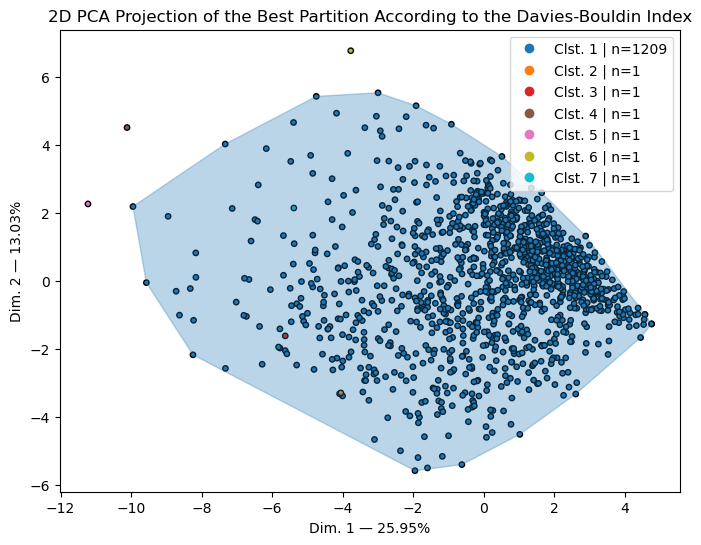

In [57]:
plot_clusters(
    data_f_lb if (db.loc[0, 'model'] == 'latent') and (db.loc[0, 'params'].get('msrt') == 'categorical') else data_n, 
    pred_clust_db,
    '2D PCA Projection of the Best Partition According to the Davies-Bouldin Index')

In [58]:
if np.unique(pred_clust_db, return_counts=True)[1].min() > 5:
    plot_cluster_profiles(data_n, pred_clust_db, feature_names = var_list, sd = 1, title = 'Davies-Bouldin')

## 3.4. Generalized Dunn 43

In [59]:
gd = best_dunn.sort_values('dunn', ascending=False).drop(columns=['silhouette', 'calinski_harabasz', 'davies_bouldin']).reset_index(drop=True)
gd

,model,params,n_clust,dunn,min_clust_size,max_clust_size,noise
0,AHC,"{'dist': 'euclidean', 'link': 'average'}",2,2.442357,1.0,1214.0,NaN
1,HDBSCAN,"{'dist': 'hamming', 'min_clust': 8, 'min_smpl'...",2,1.769585,1.0,1206.0,0.082305
2,kmeans,"{'dist': 'euclidean', 'link': 'mean'}",3,0.393015,200.0,687.0,NaN
3,latent,"{'msrt': 'gaussian_tied', 'covar': 'without'}",7,0.281502,33.0,638.0,NaN


In [60]:
pred_clust_gd = refit_best_model(gd)

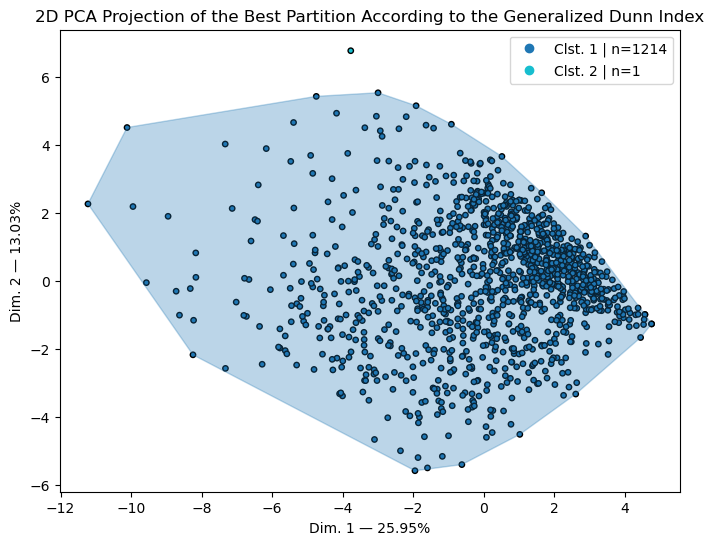

In [61]:
plot_clusters(
    data_f_lb if (gd.loc[0, 'model'] == 'latent') and (gd.loc[0, 'params'].get('msrt') == 'categorical') else data_n, 
    pred_clust_gd,
    '2D PCA Projection of the Best Partition According to the Generalized Dunn Index')

In [62]:
if np.unique(pred_clust_gd, return_counts=True)[1].min() > 5:
    plot_cluster_profiles(data_n, pred_clust_gd, feature_names = var_list, sd = 1, title = 'Generalized Dunn')

# 4. Clusterability - Hopkins Statistic

Function from the pyclustertend package, which could not be installed because its depencies are outdated.
See: https://pyclustertend.readthedocs.io/en/latest/_modules/pyclustertend/hopkins.html

In [63]:
hopkins_stat = hopkins(data_n.values, data_n.shape[0])
print(f"Hopkins stat on restricted data set: {hopkins_stat:.3f}")

Hopkins stat on restricted data set: 0.357


In [64]:
full_var_list = var_list + ['clsetown', 'clsestat', 'clsenoam', 'amancstr', 'amsports', 'lessprd']
full_var_list_n = [var + "_n" for var in full_var_list]
data_n_full = data2004_i[full_var_list_n]
hopkins_stat = hopkins(data_n_full.values, data_n.shape[0])
print(f"Hopkins stat on full data set: {hopkins_stat:.3f}")

Hopkins stat on full data set: 0.381


The inclusion of questions discared by the authors slighly improves clusterability.